In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


2023-08-23 21:01:44.056075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 21:01:44.098704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 21:01:44.099544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


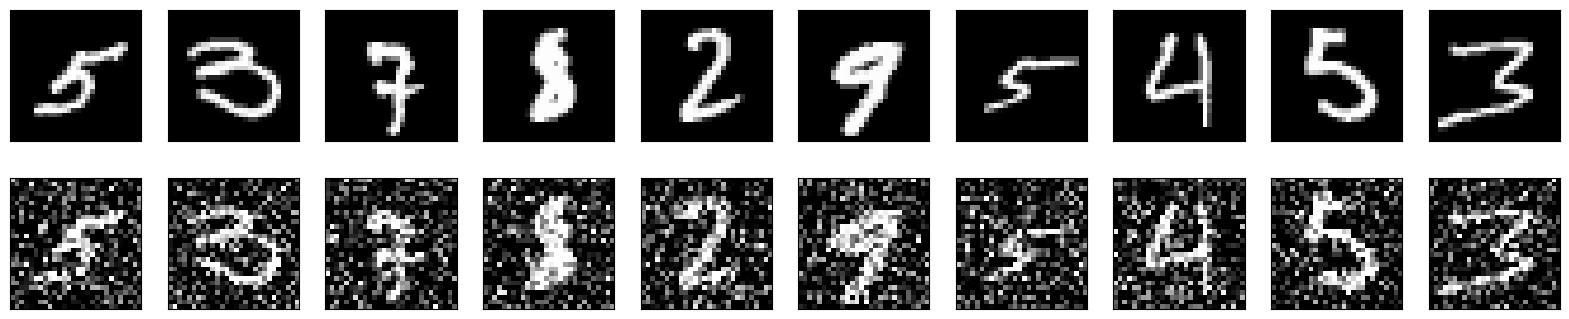

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [4]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

2023-08-23 21:01:54.218049: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)